In [22]:
import matplotlib.pyplot as plt 
import torch
import numpy as np
import os
import sys
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import random_split,DataLoader
import torch.optim as optim
from torchvision.utils import save_image


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
path='/content/drive/My Drive/George_W_Bush'

images=[]
for filename in os.listdir(path):
    img=plt.imread(os.path.join(path,filename))
    if img is not None:
        
        images.append(img)


In [25]:
 def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

gray=[]
for i in range (len(images)):
    g=rgb2gray(images[i])
    g=g/255
    gray.append(g)
    
 


In [26]:
train_count=int(530*0.7)

test_count=int(530*0.2)
val_count=int(530*0.1)


In [27]:
train,test,val=random_split(gray,(train_count,test_count,val_count))


In [28]:
trainloader=DataLoader(train,128,shuffle=True)
valloader=DataLoader(val,10,shuffle=True)
testloader=DataLoader(test,20)

for data in trainloader:
    img= data[0]
    img = img.reshape(62500)
img

tensor([0.0000, 0.0000, 0.0000,  ..., 0.1172, 0.1250, 0.1250],
       dtype=torch.float64)

In [29]:
img=img.reshape(250,250)


In [30]:



def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device




In [31]:

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.enc1 = nn.Linear(in_features=62500, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.dec1 = nn.Linear(in_features=128, out_features=256)
        self.dec2 = nn.Linear(in_features=256, out_features=62500)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
      

        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
       
        return x

net = Autoencoder()



In [32]:
LEARNING_RATE = 1e-3
msme=nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)



In [33]:
device = get_device()
print(device)
# load the neural network onto the device
net.to(device)
 



cuda:0


Autoencoder(
  (enc1): Linear(in_features=62500, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (dec1): Linear(in_features=128, out_features=256, bias=True)
  (dec2): Linear(in_features=256, out_features=62500, bias=True)
)

In [34]:
def val(net,valloader):
    val_loss=[]
    L=0
    for data in valloader:
      data=data.to(device)
      data=data.reshape(-1,62500)
      data=data.float()
      out=net(data)
      loss=msme(data,out)
      L+=loss.item()

    loss=L/len(valloader)
    val_loss.append(loss)
    print('Val loss: {:.3f}'.format( loss) )

    return val_loss


In [35]:
val_loss=val(net,valloader)

Val loss: 0.218


In [36]:
def train(net, trainloader, NUM_EPOCHS):
    train_loss = []
    for epoch in range(NUM_EPOCHS):
        L=0
        for data in trainloader:
          data=data.to(device)
          data=data.reshape(-1,62500)
          data=data.float()
          out=net(data)
          optimizer.zero_grad()
          loss=msme(data,out)
          loss.backward(retain_graph=True)
          optimizer.step()
       
          L+= loss.item()

        loss=L/len(trainloader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss))

       

    return train_loss




In [37]:
train_loss = train(net, trainloader,500)


Epoch 1 of 500, Train Loss: 3.721
Epoch 2 of 500, Train Loss: 0.217
Epoch 3 of 500, Train Loss: 0.167
Epoch 4 of 500, Train Loss: 0.157
Epoch 5 of 500, Train Loss: 0.144
Epoch 6 of 500, Train Loss: 0.132
Epoch 7 of 500, Train Loss: 0.123
Epoch 8 of 500, Train Loss: 0.117
Epoch 9 of 500, Train Loss: 0.113
Epoch 10 of 500, Train Loss: 0.110
Epoch 11 of 500, Train Loss: 0.108
Epoch 12 of 500, Train Loss: 0.107
Epoch 13 of 500, Train Loss: 0.105
Epoch 14 of 500, Train Loss: 0.104
Epoch 15 of 500, Train Loss: 0.103
Epoch 16 of 500, Train Loss: 0.103
Epoch 17 of 500, Train Loss: 0.102
Epoch 18 of 500, Train Loss: 0.101
Epoch 19 of 500, Train Loss: 0.101
Epoch 20 of 500, Train Loss: 0.100
Epoch 21 of 500, Train Loss: 0.099
Epoch 22 of 500, Train Loss: 0.098
Epoch 23 of 500, Train Loss: 0.097
Epoch 24 of 500, Train Loss: 0.096
Epoch 25 of 500, Train Loss: 0.094
Epoch 26 of 500, Train Loss: 0.093
Epoch 27 of 500, Train Loss: 0.092
Epoch 28 of 500, Train Loss: 0.090
Epoch 29 of 500, Train Loss: 

Text(0, 0.5, 'Loss')

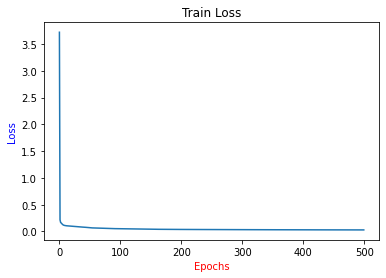

In [38]:
plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs',c='red')
plt.ylabel('Loss',c='blue')

In [39]:
def test_image_reconstruction(net, testloader):
  output=[]
  for data in testloader:
        batch1=data
        batch1 = batch1.to(device)
        batch1 = batch1.reshape(-1,62500)
        batch1=batch1.float()
        output = net(batch1)  
        output=output.reshape(-1,250,250)
       # output=output.cpu().data.numpy()
        break





  return output
        
       
for data in testloader:
   batch=data
   break
batch.shape

torch.Size([20, 250, 250])

In [40]:
output=test_image_reconstruction(net, testloader)


output=output.detach().cpu().clone()
batchout=output


In [41]:
output.shape

torch.Size([20, 250, 250])

In [42]:
batch.shape

torch.Size([20, 250, 250])

In [56]:
Testloss=msme(batch,output)
Testloss

tensor(0.0363, dtype=torch.float64)

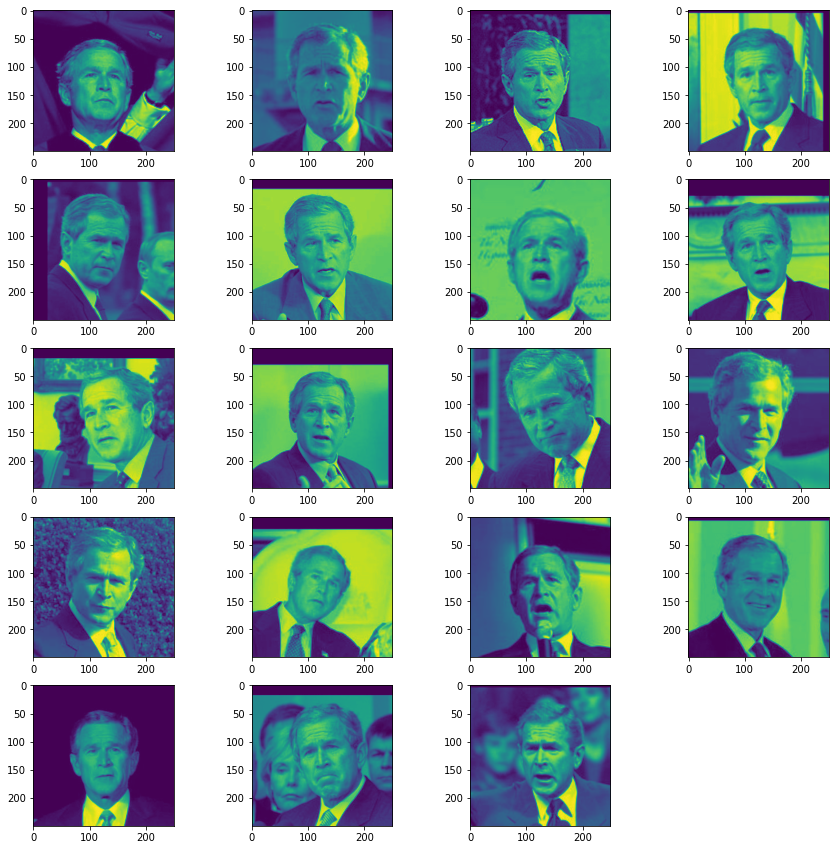

In [229]:
w=10
h=10
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1,20):
    fig.add_subplot(rows, columns, i)
    plt.imshow(batch[i])
plt.show()

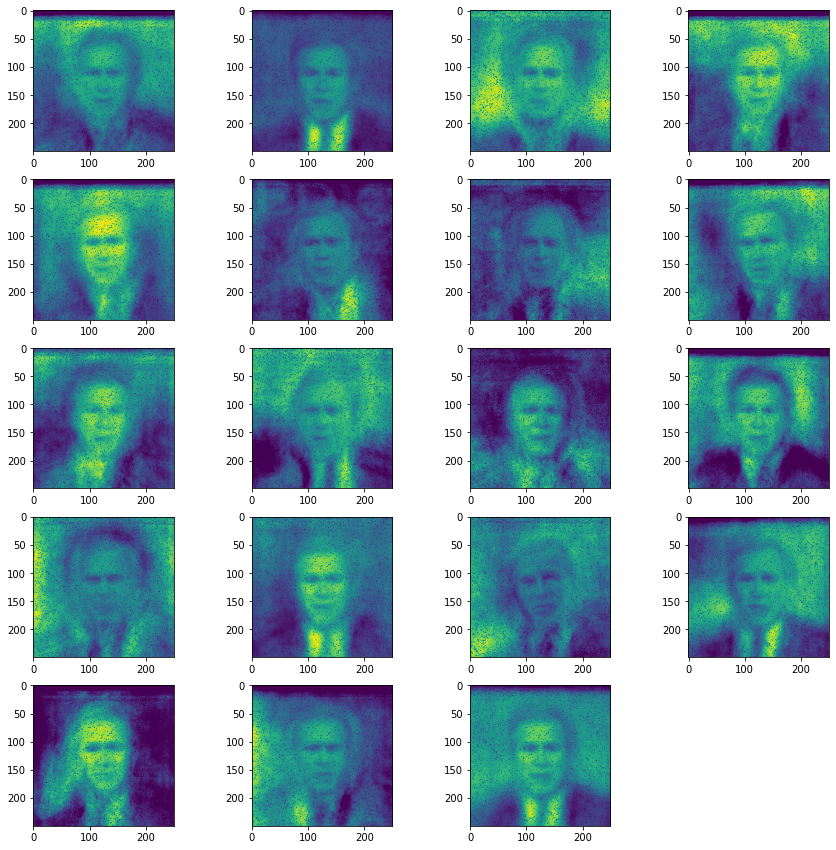

In [43]:
w=10
h=10
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1,20):
    fig.add_subplot(rows, columns, i)
    plt.imshow(batchout[i])
plt.show()

In [44]:
lossAE=msme(batch,batchout)
lossAE

tensor(0.0363, dtype=torch.float64)

In [45]:
torch.save(net.state_dict(), 'parameters')

In [46]:
net.state_dict()

OrderedDict([('enc1.weight',
              tensor([[-0.0071, -0.0017, -0.0073,  ..., -0.0081, -0.0070, -0.0086],
                      [ 0.0006,  0.0040,  0.0077,  ..., -0.0034, -0.0065, -0.0049],
                      [-0.0052, -0.0094, -0.0077,  ..., -0.0066, -0.0073, -0.0091],
                      ...,
                      [-0.0073, -0.0022, -0.0071,  ..., -0.0078, -0.0052, -0.0080],
                      [ 0.0067,  0.0085,  0.0067,  ..., -0.0123, -0.0060, -0.0031],
                      [-0.0033, -0.0083, -0.0057,  ..., -0.0090, -0.0067, -0.0057]],
                     device='cuda:0')),
             ('enc1.bias',
              tensor([-6.2702e-03, -6.2386e-03, -2.6126e-03, -7.2244e-03,  2.6268e-05,
                      -3.4277e-03, -3.4696e-03, -5.0539e-03, -2.6042e-03, -8.7457e-03,
                      -2.7837e-03, -9.5601e-03, -7.1200e-03, -9.4147e-03, -6.1852e-03,
                      -2.0111e-03, -6.5835e-03, -7.5048e-03, -3.8758e-03,  2.7871e-03,
                      -5

In [49]:
net.load_state_dict(torch.load('parameters'))
net.state_dict()

OrderedDict([('enc1.weight',
              tensor([[-0.0071, -0.0017, -0.0073,  ..., -0.0081, -0.0070, -0.0086],
                      [ 0.0006,  0.0040,  0.0077,  ..., -0.0034, -0.0065, -0.0049],
                      [-0.0052, -0.0094, -0.0077,  ..., -0.0066, -0.0073, -0.0091],
                      ...,
                      [-0.0073, -0.0022, -0.0071,  ..., -0.0078, -0.0052, -0.0080],
                      [ 0.0067,  0.0085,  0.0067,  ..., -0.0123, -0.0060, -0.0031],
                      [-0.0033, -0.0083, -0.0057,  ..., -0.0090, -0.0067, -0.0057]],
                     device='cuda:0')),
             ('enc1.bias',
              tensor([-6.2702e-03, -6.2386e-03, -2.6126e-03, -7.2244e-03,  2.6268e-05,
                      -3.4277e-03, -3.4696e-03, -5.0539e-03, -2.6042e-03, -8.7457e-03,
                      -2.7837e-03, -9.5601e-03, -7.1200e-03, -9.4147e-03, -6.1852e-03,
                      -2.0111e-03, -6.5835e-03, -7.5048e-03, -3.8758e-03,  2.7871e-03,
                      -5

In [50]:
from sklearn.decomposition import PCA

In [51]:
n=5
pca=PCA(n)
pca

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [52]:
batchx=batch.reshape(20,62500)
batchproj=pca.fit_transform(batchx)


In [53]:
def loss_pca(n):
  pca=PCA(n)

  batchproj=pca.fit_transform(batchx)

  inv = pca.inverse_transform(batchproj)
  inv=torch.tensor(inv)

  #batch_proj=np.reshape(inv)
 
 # batch_proj=batch_proj.reshape(20,62500)

  Loss=msme(batchx,inv)
  return Loss



N=[5,10,20]
for i in N:
      Loss=loss_pca(i)
      print(Loss)

tensor(0.0225, dtype=torch.float64)
tensor(0.0101, dtype=torch.float64)
tensor(9.2679e-31, dtype=torch.float64)


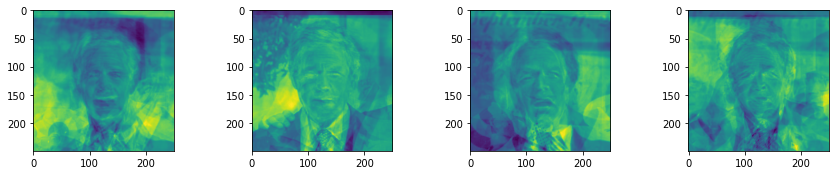

In [54]:
w=10
h=10
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1,n):
    fig.add_subplot(rows, columns, i)
    plt.imshow((pca.components_[i,:]).reshape(250,250))
plt.show()

In [272]:
inv = pca.inverse_transform(batchproj)

In [273]:
batch_proj=np.reshape(inv,(20,250,250))

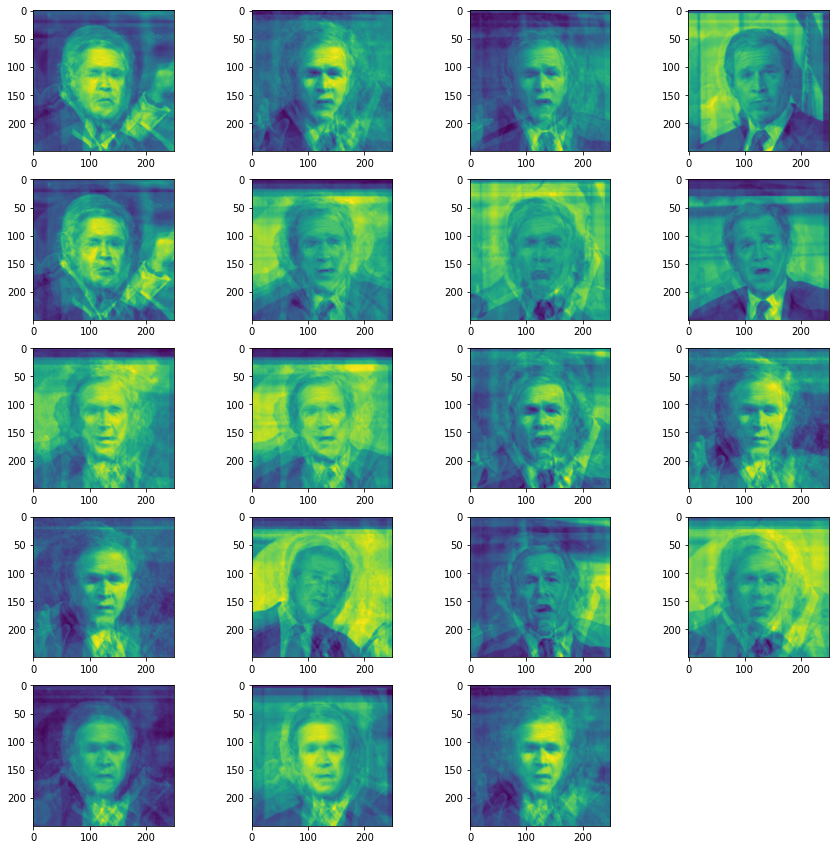

In [274]:
w=10
h=10
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1,20):
    fig.add_subplot(rows, columns, i)
    plt.imshow(batch_proj[i])
plt.show()

In [275]:
batch_proj=batch_proj.reshape(20,62500)
batch_proj.shape

(20, 62500)

In [276]:
batchx.shape


torch.Size([20, 62500])

In [277]:

batch_proj=torch.tensor(batch_proj)
batch_proj

tensor([[ 0.0471,  0.0484,  0.0497,  ...,  0.3190,  0.3122,  0.3126],
        [ 0.0541,  0.0541,  0.0542,  ...,  0.3491,  0.3413,  0.3475],
        [ 0.1980,  0.2021,  0.2065,  ...,  0.3401,  0.3404,  0.3335],
        ...,
        [-0.0243, -0.0216, -0.0186,  ...,  0.0590,  0.0758,  0.0969],
        [-0.0272, -0.0262, -0.0249,  ...,  0.1930,  0.1931,  0.1990],
        [ 0.1068,  0.1101,  0.1137,  ...,  0.3220,  0.3229,  0.3212]],
       dtype=torch.float64)

In [278]:
lossPca=msme(batchx,batch_proj)

torch.Size([20, 62500])

torch.Size([20, 62500])